The general idea behind this notebook is to show how we can use NMF to get a meaningful representation of images. We'll be working with the [Random Sample of NIH Chest X-ray Dataset](https://www.kaggle.com/datasets/nih-chest-xrays/sample), which a 5% sample of the [NIH Chest X-rays](https://www.kaggle.com/datasets/nih-chest-xrays/data?resource=download) dataset. The random sample contains 5606 X-ray images and class labels.

In [1]:
from sklearn.decomposition import MiniBatchNMF
from sklearn.preprocessing import normalize

from skimage import io, transform
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import time

BASE_PATH = '../data/nih/images/'
OUTPUT_SHAPE = (128, 128)
SEED = 101

In [2]:
def load_image(fname, output_shape=OUTPUT_SHAPE):
    """Function to load image and resize image to target output_shape. 
    Assumes grayscale input and will select first channel if multichannel image is read in."""
    img = io.imread(fname)
    if len(img.shape)>2:
        img = img[:,:,0]
    img = transform.resize(img, output_shape=output_shape)
    return img

def load_image_batch(fnames, n_jobs=4, output_shape=OUTPUT_SHAPE, verbose=False):
    """Helper function for efficiently loading images from disk."""
    if verbose:
        img_batch = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(load_image)(fname) for fname in tqdm(fnames))
    else:
        img_batch = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(load_image)(fname) for fname in fnames)
    img_batch = np.array(img_batch)
    return img_batch

First we can load a reference CSV to get all of the filenames. We could also get the labels, but we are simply conentrating on getting data to a MiniBatchNMF model/transformer. Note that we are using multiprocessing to greatly speed up the data loading process. We are also going to load _all_ of the images into memory. Let's also select a subset (10%) of the files to serve as a validation set.

In [3]:
df = pd.read_csv('../data/nih/sample_labels.csv')
df['val'] = np.random.choice([0,1], size=df.shape[0], p=[0.9, 0.1])
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,val
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0


In [4]:
idx_train = df['val'] == 0
fnames_train = [BASE_PATH + fname for fname in df.loc[idx_train, 'Image Index'].tolist()]
fnames_val = [BASE_PATH + fname for fname in df.loc[~idx_train, 'Image Index'].tolist()]

In [5]:
X_train = load_image_batch(fnames_train, n_jobs=-1, verbose=True)
X_train.shape

100%|█████████████████████████████████████████████████████████████████████████████| 5018/5018 [00:27<00:00, 180.77it/s]


(5018, 128, 128)

In [6]:
X_val = load_image_batch(fnames_val, n_jobs=-1, verbose=True)
X_val.shape

100%|███████████████████████████████████████████████████████████████████████████████| 588/588 [00:02<00:00, 218.87it/s]


(588, 128, 128)

Just so we know what we are looking at, let's examine a few of the validation images.

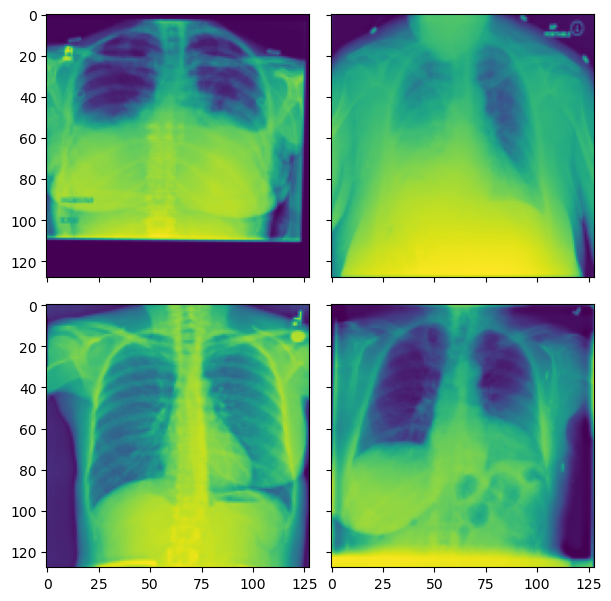

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
for i, j in enumerate([1, 2, 5, 10]):
    ax.flat[i].imshow(X_val[j])
plt.show()

Now we can process our data. The NMF/MiniBatchNMF models is expecting a 1D array per instance, so we are simply going to reshape our data. It will also help to normalize (L2). Note that I have plenty of RAM on this machine (32GB), but I am going to use in-place operations to help reduce memory usage.

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_train = normalize(X_train)
X_train.shape

(5018, 16384)

Now that we have our dataset, it is relatively straightforward to train a MiniBatchNMF model. Let's start with a relatively small number of features (20) and initialize using nndsvda. We'll also limit the number of epochs to 200. Remember that the number of updates (i.e., minibatches) will be _up to_ the max_iter multiplied by len(X)//batch_size + 1.

In [9]:
nmf = MiniBatchNMF(
    n_components=20,
    init='nndsvda', 
    batch_size=2048, # This really dominates noise in the loss as you expect
    beta_loss='frobenius',
    max_no_improvement=10, # Might need to be increased to account for batch_size
    max_iter=200, # Maximum number of epochs
    random_state=SEED,
    verbose=True # Sometimes just nice to see that the training is working!
)

In [10]:
start = time.time()
nmf.fit(X_train)
end = time.time()
print(f'Time to train a MiniBatchNMF model: {end-start:0.2f}s')

Minibatch step 1/600: mean batch cost: 0.03965085132979385
Minibatch step 2/600: mean batch cost: 0.046690696410484664, ewa cost: 0.046690696410484664
Minibatch step 3/600: mean batch cost: 0.03827366350758745, ewa cost: 0.045144471198994084
Minibatch step 4/600: mean batch cost: 0.03418546645376104, ewa cost: 0.04067265575403746
Minibatch step 5/600: mean batch cost: 0.04184705012973171, ewa cost: 0.04115186668876984
Minibatch step 6/600: mean batch cost: 0.036254597857048494, ewa cost: 0.0402522289396471
Minibatch step 7/600: mean batch cost: 0.03278089295226389, ewa cost: 0.03720355468139629
Minibatch step 8/600: mean batch cost: 0.039829065186981025, ewa cost: 0.03827489270001305
Minibatch step 9/600: mean batch cost: 0.034908532901202056, ewa cost: 0.03765648589895632
Minibatch step 10/600: mean batch cost: 0.03163999691917884, ewa cost: 0.035201461107048714
Minibatch step 11/600: mean batch cost: 0.038391880058630506, ewa cost: 0.03650330968502033
Minibatch step 12/600: mean batc

Minibatch step 92/600: mean batch cost: 0.026012915943251433, ewa cost: 0.02427974434464671
Minibatch step 93/600: mean batch cost: 0.023283911654325532, ewa cost: 0.02409680795483278
Minibatch step 94/600: mean batch cost: 0.02115999865041697, ewa cost: 0.022898444644324
Minibatch step 95/600: mean batch cost: 0.02580739459964513, ewa cost: 0.02408543996380949
Minibatch step 96/600: mean batch cost: 0.023100736921529707, ewa cost: 0.023904548111850547
Minibatch step 97/600: mean batch cost: 0.020996071801221355, ewa cost: 0.02271774606280321
Minibatch step 98/600: mean batch cost: 0.025608072861642222, ewa cost: 0.02389714221423224
Minibatch step 99/600: mean batch cost: 0.022923256246366597, ewa cost: 0.02371823747974885
Minibatch step 100/600: mean batch cost: 0.020837149738467287, ewa cost: 0.02254261132032573
Minibatch step 101/600: mean batch cost: 0.025414636608520804, ewa cost: 0.02371453955109351
Minibatch step 102/600: mean batch cost: 0.022751150532789824, ewa cost: 0.023537

Minibatch step 182/600: mean batch cost: 0.021731981274278694, ewa cost: 0.02025838604105467
Minibatch step 183/600: mean batch cost: 0.019483255651361154, ewa cost: 0.020115993090407645
Minibatch step 184/600: mean batch cost: 0.01776821423286396, ewa cost: 0.019157983307532676
Minibatch step 185/600: mean batch cost: 0.021636720662664213, ewa cost: 0.02016943062837535
Minibatch step 186/600: mean batch cost: 0.01939947292371343, ewa cost: 0.020027987909965652
Minibatch step 187/600: mean batch cost: 0.0176933683224078, ewa cost: 0.019075347759473824
Minibatch step 188/600: mean batch cost: 0.02154362403811778, ewa cost: 0.020082526444204413
Minibatch step 189/600: mean batch cost: 0.01931767568454327, ewa cost: 0.01994202188146132
Minibatch step 190/600: mean batch cost: 0.017620267784950835, ewa cost: 0.018994631487029467
Minibatch step 191/600: mean batch cost: 0.021452629351303956, ewa cost: 0.019997616070817903
Minibatch step 192/600: mean batch cost: 0.019237809303044286, ewa co

Minibatch step 271/600: mean batch cost: 0.016159073794161215, ewa cost: 0.017377676662055277
Minibatch step 272/600: mean batch cost: 0.019609882326592613, ewa cost: 0.018288526871454054
Minibatch step 273/600: mean batch cost: 0.017647516678269217, ewa cost: 0.018170772060113864
Minibatch step 274/600: mean batch cost: 0.016119467541951937, ewa cost: 0.01733373845716594
Minibatch step 275/600: mean batch cost: 0.019559248539890356, ewa cost: 0.018241856538341393
Minibatch step 276/600: mean batch cost: 0.017604483061689397, ewa cost: 0.018124769798856806
Minibatch step 277/600: mean batch cost: 0.016080647968845802, ewa cost: 0.01729066708758712
Minibatch step 278/600: mean batch cost: 0.019509592188524594, ewa cost: 0.018196098170814842
Minibatch step 279/600: mean batch cost: 0.01756229423114835, ewa cost: 0.01807966716217318
Minibatch step 280/600: mean batch cost: 0.016042595317600758, ewa cost: 0.017248441193317966
Minibatch step 281/600: mean batch cost: 0.019460890431060193, e

Minibatch step 359/600: mean batch cost: 0.01846503449433931, ewa cost: 0.017236237062260015
Minibatch step 360/600: mean batch cost: 0.016679957117785547, ewa cost: 0.017134047361362335
Minibatch step 361/600: mean batch cost: 0.015245496397348861, ewa cost: 0.016363425250523603
Minibatch step 362/600: mean batch cost: 0.01843496934606171, ewa cost: 0.017208717601123732
Minibatch step 363/600: mean batch cost: 0.01665487375794909, ewa cost: 0.017106975416742977
Minibatch step 364/600: mean batch cost: 0.015222659014522024, ewa cost: 0.01633808121635475
Minibatch step 365/600: mean batch cost: 0.01840538079421062, ewa cost: 0.017181641594009426
Minibatch step 366/600: mean batch cost: 0.016630215102157536, ewa cost: 0.017080343481738567
Minibatch step 367/600: mean batch cost: 0.01520018820287943, ewa cost: 0.01631314722529236
Minibatch step 368/600: mean batch cost: 0.01837625784333113, ewa cost: 0.0171549983003558
Minibatch step 369/600: mean batch cost: 0.01660597066956626, ewa cost

Minibatch step 447/600: mean batch cost: 0.01609308233023813, ewa cost: 0.01649526736020641
Minibatch step 448/600: mean batch cost: 0.01470433946766866, ewa cost: 0.015764480286303777
Minibatch step 449/600: mean batch cost: 0.017733034496336918, ewa cost: 0.01656774767465761
Minibatch step 450/600: mean batch cost: 0.016076996554069144, ewa cost: 0.016477595745352454
Minibatch step 451/600: mean batch cost: 0.014689333959313036, ewa cost: 0.015747896574639417
Minibatch step 452/600: mean batch cost: 0.017713482071312125, ewa cost: 0.016549952581251432
Minibatch step 453/600: mean batch cost: 0.016061127716597408, ewa cost: 0.016460154508884228
Minibatch step 454/600: mean batch cost: 0.014674525930860972, ewa cost: 0.015731529817154477
Minibatch step 455/600: mean batch cost: 0.017694175560730274, ewa cost: 0.016532386259243186
Minibatch step 456/600: mean batch cost: 0.016045471334724948, ewa cost: 0.016442939046570182
Minibatch step 457/600: mean batch cost: 0.014659911337014442, e

Minibatch step 535/600: mean batch cost: 0.014336168229726162, ewa cost: 0.015357562978092898
Minibatch step 536/600: mean batch cost: 0.017250518070263218, ewa cost: 0.01612998219083743
Minibatch step 537/600: mean batch cost: 0.015689727542823204, ewa cost: 0.01604910656113647
Minibatch step 538/600: mean batch cost: 0.014325502680736053, ewa cost: 0.01534579101081568
Minibatch step 539/600: mean batch cost: 0.017236485860434685, ewa cost: 0.016117287932915645
Minibatch step 540/600: mean batch cost: 0.015678620886302088, ewa cost: 0.016036703948660278
Minibatch step 541/600: mean batch cost: 0.014314946633302858, ewa cost: 0.015334141888119933
Minibatch step 542/600: mean batch cost: 0.017222597499915674, ewa cost: 0.01610472509054226
Minibatch step 543/600: mean batch cost: 0.01566763664209433, ewa cost: 0.016024431097820806
Minibatch step 544/600: mean batch cost: 0.014304498122756411, ewa cost: 0.015322613458264744
Minibatch step 545/600: mean batch cost: 0.017208850709187016, ew

C:\Users\jkkph\anaconda3\envs\sklearn1dot2\lib\site-packages\sklearn\decomposition\_nmf.py:2239: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Time to train a MiniBatchNMF model: 102.07s


Now we can examine nome of the components of the trained model to see what the features represent. Remember, the general idea is that each instance (i.e., image) can be represented as a linear combination of these different components. Also as a fun bonus, let's remember that since NMF is a transformer, we get feature names for free!

In [11]:
features = nmf.get_feature_names_out()
print(features)

['minibatchnmf0' 'minibatchnmf1' 'minibatchnmf2' 'minibatchnmf3'
 'minibatchnmf4' 'minibatchnmf5' 'minibatchnmf6' 'minibatchnmf7'
 'minibatchnmf8' 'minibatchnmf9' 'minibatchnmf10' 'minibatchnmf11'
 'minibatchnmf12' 'minibatchnmf13' 'minibatchnmf14' 'minibatchnmf15'
 'minibatchnmf16' 'minibatchnmf17' 'minibatchnmf18' 'minibatchnmf19']


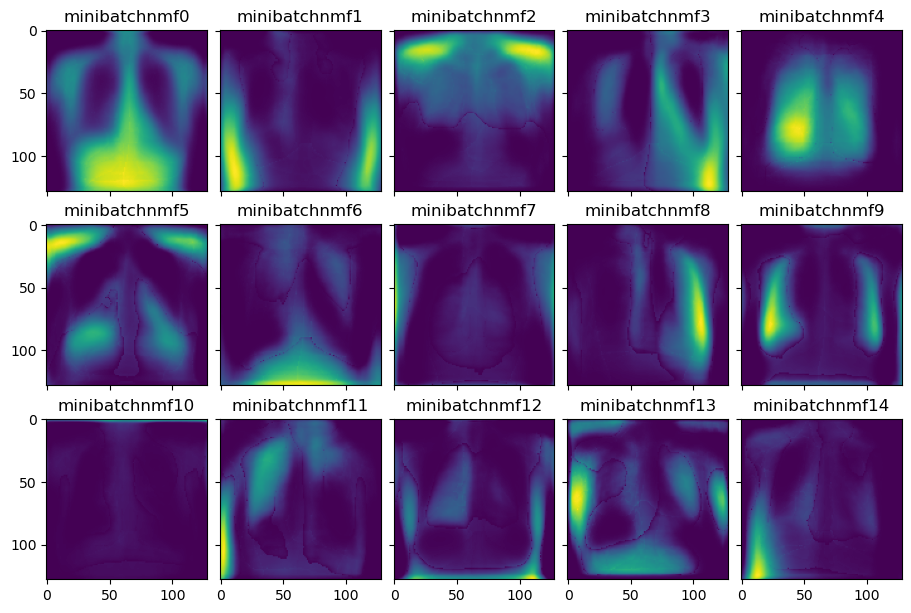

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(9,6), sharex=True, sharey=True, constrained_layout=True)
for i in range(15):
    ax.flat[i].set_title(features[i], fontsize=12)
    ax.flat[i].imshow(nmf.components_[i].reshape(OUTPUT_SHAPE))
plt.show()

Finally, let's transform an image to topic space and back, so we can see how well the model is encoding the relevant features.

In [13]:
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_val = normalize(X_val)
X_val.shape

(588, 16384)

In [14]:
X_val_nmf = nmf.transform(X_val)
X_val_nmf_invert = nmf.inverse_transform(X_val_nmf)

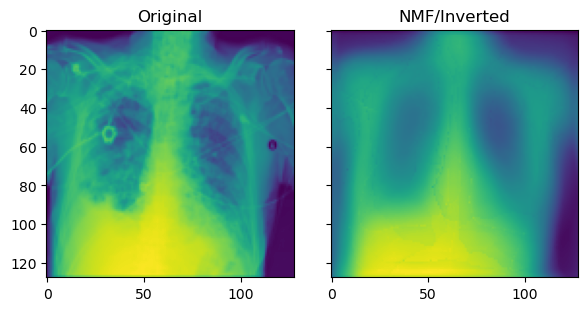

In [15]:
def plot_comparison(i):
    """Simple helper function to plot original image and transformed/inverted NMF image."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
    ax.flat[0].set_title('Original')
    ax.flat[0].imshow(X_val[i].reshape(OUTPUT_SHAPE))
    ax.flat[1].set_title('NMF/Inverted')
    ax.flat[1].imshow(X_val_nmf_invert[i].reshape(OUTPUT_SHAPE))
    plt.show()
    
plot_comparison(0)

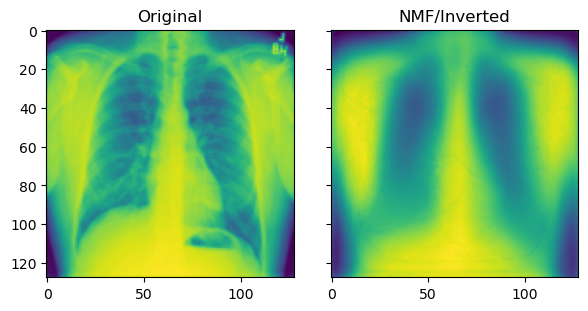

In [16]:
plot_comparison(111)

This isn't significantly different from the standard NMF implementation, we are simply using a different optimization algorithm (SGD). The real advantage to this method is the availability of the partial_fit method, which will allow us to train on batches of data (and therefore reduce memory usage at the cost of training time). As an example, let's load the same model and train on a single batch of data.

In [17]:
nmf = MiniBatchNMF(
    n_components=20,
    init='nndsvda', 
    beta_loss='frobenius',
    random_state=SEED,
    verbose=True,
)

In [18]:
X_batch = load_image_batch(fnames_train[:256])
X_batch.shape

(256, 128, 128)

In [19]:
X_batch = X_batch.reshape(X_batch.shape[0], X_batch.shape[1]*X_batch.shape[2])
X_batch = normalize(X_batch)
X_batch.shape

(256, 16384)

In [20]:
nmf.partial_fit(X_batch)

MiniBatchNMF(init='nndsvda', n_components=20, random_state=101, verbose=True)

Now let's apply this model to the validation images and see what the comparison looks like.

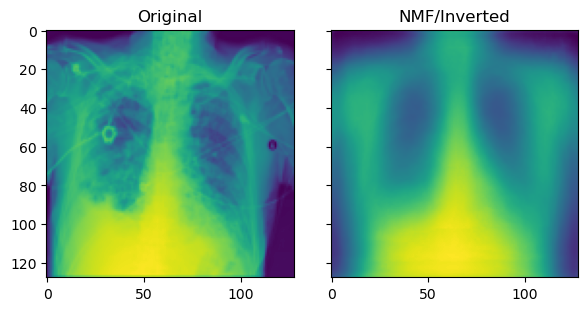

In [21]:
X_val_nmf = nmf.transform(X_val)
X_val_nmf_invert = nmf.inverse_transform(X_val_nmf)

plot_comparison(0)

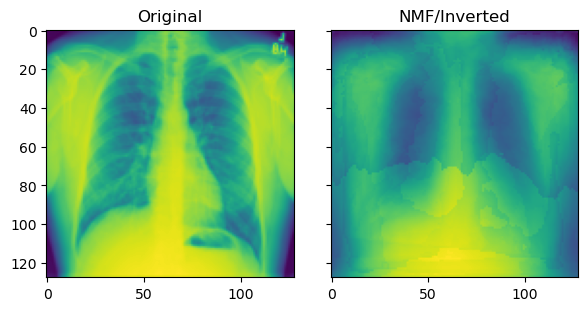

In [22]:
plot_comparison(111)

Pretty poor! However, that is to be expected. We've instantiated a model and only trained a single step on a batch of 256 images. It is fairly straightforward to write a loop to train on multiple batches.

In [23]:
def get_batches(fnames, batch_size=128, n_jobs=-1):
    """Streams images from disk in batches. Uses joblib.Parallel to speed up data loader."""
    splits = np.ceil(len(fnames)/batch_size)
    fname_batches = np.array_split(fnames, splits)
    for fname_batch in fname_batches:
        X_batch = []
        X_batch = load_image_batch(fname_batch, n_jobs=n_jobs)
        X_batch = X_batch.reshape(X_batch.shape[0], X_batch.shape[1]*X_batch.shape[2])
        X_batch = normalize(X_batch)
        yield X_batch

In [24]:
nmf = MiniBatchNMF(
    n_components=20,
    init='nndsvda', 
    beta_loss='frobenius',
    random_state=SEED,
    verbose=True,
)

batch_size = 512
epochs = 5
rng = np.random.RandomState(SEED)
for i in range(epochs):
    print(f'Working on Epoch {i}')
    batches = get_batches(fnames_train, batch_size)
    for X_batch in tqdm(batches, total=np.ceil(len(fnames_train)/batch_size)):
        nmf.partial_fit(X_batch)

Working on Epoch 0


100%|████████████████████████████████████████████████████████████████████████████████| 10/10.0 [00:31<00:00,  3.15s/it]


Working on Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 10/10.0 [00:28<00:00,  2.88s/it]


Working on Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 10/10.0 [00:28<00:00,  2.86s/it]


Working on Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 10/10.0 [00:28<00:00,  2.88s/it]


Working on Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 10/10.0 [00:28<00:00,  2.84s/it]


Next, we'll compare the results.

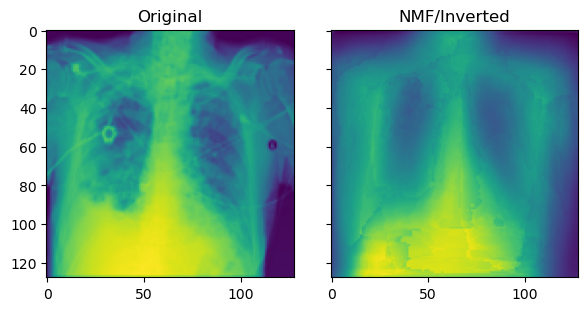

In [25]:
X_val_nmf = nmf.transform(X_val)
X_val_nmf_invert = nmf.inverse_transform(X_val_nmf)

plot_comparison(0)

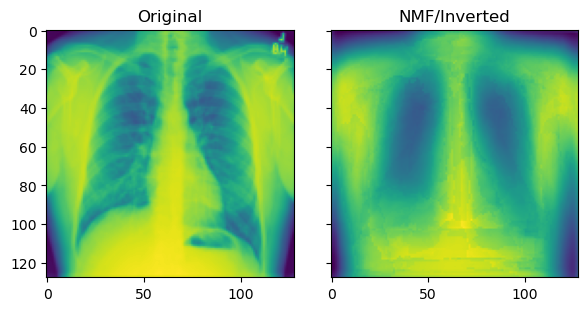

In [26]:
plot_comparison(111)

To my eye, this is acceptable and probably could be improved with additional training. That aside, while this method is clearly slower, we are able to run with less memory usage! Clearly this dataset is able to fit in memory, but not all datasets will, so this is a handy tool for those large datasets.

Just to show the difference, I used [memory_profiler](https://pypi.org/project/memory-profiler/) to measure memory usage for in-core and out-of-core training: `mprof run python nmf.py 0`. It took ~36 seconds and ~284 seconds to train in-core and out-of-core, respectively.
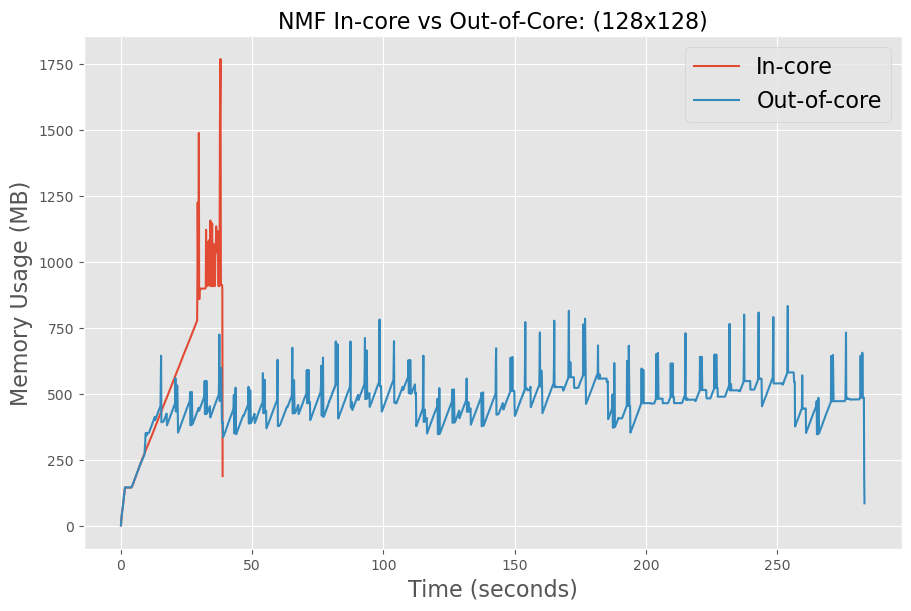
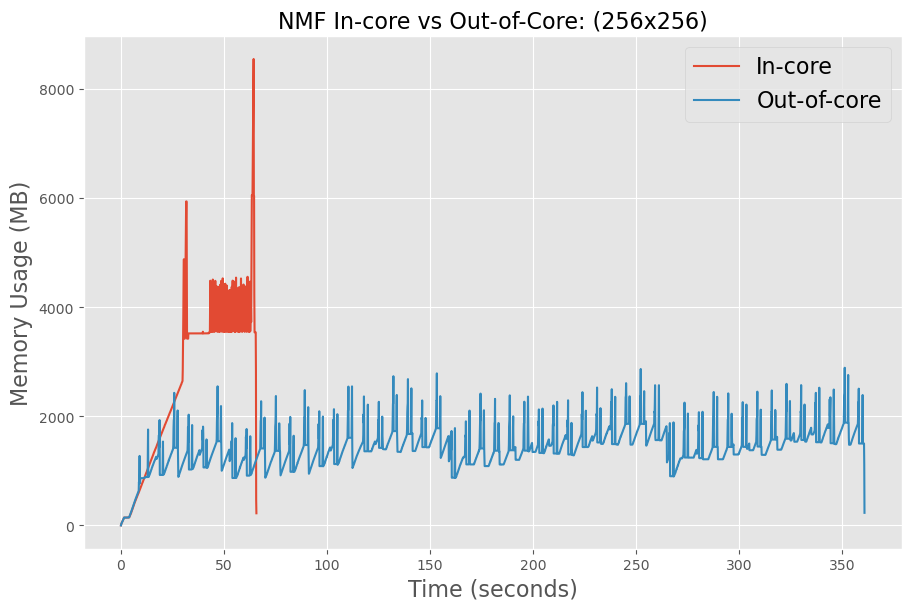
Note the significant decrease in memory usage over the life of the script. 

This is a pretty powerful technique that can be used with any model or transformer in sklearn that implements the partial_fit method: [6.1.3. Incremental Learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning). Fair warning, most transformers/models that implement partial_fit do not monitor loss, so I recommend creating a wrapper function/class for early stopping (to prevent overfit).